In [1]:
import pandas as pd
import numpy as np
import math
import glob
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import cooler
from src.Graph_creation import compute_nx_graph_from_regions, compute_ptg_graph_from_regions

In [2]:
coolerpath ={'WT':'/disk2/dh486/cooler_files/WT/manually_downsampled/KR/KR_downsampled_WT_merged_10000.cool',
             'KO':'/disk2/dh486/cooler_files/KO/KR/KR_KO_merged_10000.cool'
            }

In [3]:
x = compute_ptg_graph_from_regions(coolerpath['WT'],
                                   {'chr2':np.array([[8651256,10658971],
                                                     [10678978,11658978]
                                                    ]),
                                    'chr3':np.array([[8651256,10658971],
                                                     [10678978,11658978]
                                                    ])
                                   },
                                   names = {'chr2': ['Ppp2r2c','reg2'],
                                            'chr3': ['Ppp3r3c','reg4']
                                           },
                                   balance = True, 
                                   join = False,
                                   record_cistrans_interactions = False,
                                   record_node_chromosome_as_onehot = False
                                  )

x

{'chr2': [{'edge_index': array([[  0.,   0.,   0., ..., 198., 198., 199.],
          [  0.,   1.,   2., ..., 199., 200., 200.]]),
   'edge_attrs': array([[ 45.51099203,   0.        ],
          [ 71.47081371,   1.        ],
          [ 29.6403106 ,   0.        ],
          ...,
          [ 87.46075588,   1.        ],
          [ 41.5707432 ,   0.        ],
          [113.3756405 ,   1.        ]]),
   'x': array([], shape=(201, 0), dtype=float64),
   'cooler_idxs': array([20413, 20414, 20415, 20416, 20417, 20418, 20419, 20420, 20421,
          20422, 20423, 20424, 20425, 20426, 20427, 20428, 20429, 20430,
          20431, 20432, 20433, 20434, 20435, 20436, 20437, 20438, 20439,
          20440, 20441, 20442, 20443, 20444, 20445, 20446, 20447, 20448,
          20449, 20450, 20451, 20452, 20453, 20454, 20455, 20456, 20457,
          20458, 20459, 20460, 20461, 20462, 20463, 20464, 20465, 20466,
          20467, 20468, 20469, 20470, 20471, 20472, 20473, 20474, 20475,
          20476, 20477,

In [17]:
def draw_circular(graph, ax, cmap = plt.cm.Blues, weightnorm = None):
    pos = nx.circular_layout(graph)
    #nx.draw_networkx_nodes(graph, pos = pos,node_size=30,ax=ax)

    edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())

    if weightnorm is None:
        weightnorm = np.percentile(weights,90)
    normalize = mpl.colors.Normalize(vmin=0, vmax=weightnorm)
    for jdx in np.argsort(weights):
        nx.draw_networkx_edges(graph, 
                           pos, 
                           ax = ax,
                           edgelist=[edges[jdx]], 
                           edge_color = cmap(normalize(weights[jdx])), 
                           connectionstyle='arc3,rad=0.3')

    labels = {item[0]: item[1].split(":")[1].split("-")[0] for item in graph.nodes(data='bin_regions') if int(item[0])%20 == 0}
    poslabels = nx.draw_networkx_labels(graph,{key: 1.1*pos[key] for key in pos},labels = labels,ax= ax)
    
    return weightnorm, pos

def highlight_nodes(graph, nodes,ax, pos, **kwargs):
    nx.draw_networkx_nodes(graph, pos = pos,ax=ax, **kwargs)
    
def compare_gene(gene_reg, gene_name):
    gene_intregs = gene_reg.split(":")[1]
    gene_intregs = [int(item.replace(',', '')) for item in gene_intregs.split("-")]
    c = cooler.Cooler(coolerpath['WT'])
    mynodes = c.bins().fetch(gene_reg).index.values

    regions = {
        gene_reg.split(":")[0]: np.array([[gene_intregs[0]-int(4e5),gene_intregs[1]+int(4e5)]])
    }
    chrom = gene_reg.split(":")[0]
    graphs = {cond: compute_nx_graph_from_regions(coolerpath[cond],
                                                  regions,
                                                  join= True,
                                                  force_disjoint = True,
                                                  balance = True) for cond in ['WT','KO']}

    fig, ax = plt.subplots(1,2, figsize = (16,8))
    fig.tight_layout()
    for idx in [0,1]:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
    
    pos = {}
    KO_weightnorm,pos['KO'] = draw_circular(graphs['KO'],
                                        ax[0],
                                        cmap = plt.cm.Reds)
    ax[0].set_title(f"KO contacts\n{graphs['KO'].graph['regions']}\n{gene_name} highlighted",
                size = 15)

    nx.draw_networkx_nodes(graphs['KO'],
                       pos = pos['KO'],
                       ax=ax[0],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    WT_weightnorm, pos['WT'] = draw_circular(graphs['WT'],
                                         ax[1],
                                         weightnorm = KO_weightnorm)
    ax[1].set_title(f"WT contacts\n{graphs['WT'].graph['regions']}\n{gene_name} highlighted",
                size = 15)
    nx.draw_networkx_nodes(graphs['WT'],
                       pos = pos['WT'],
                       ax=ax[1],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    for idx in [0,1]:
        ax[idx].set_xlim([-1.3,1.2])
        ax[idx].set_ylim([-1.2,1.2])
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])


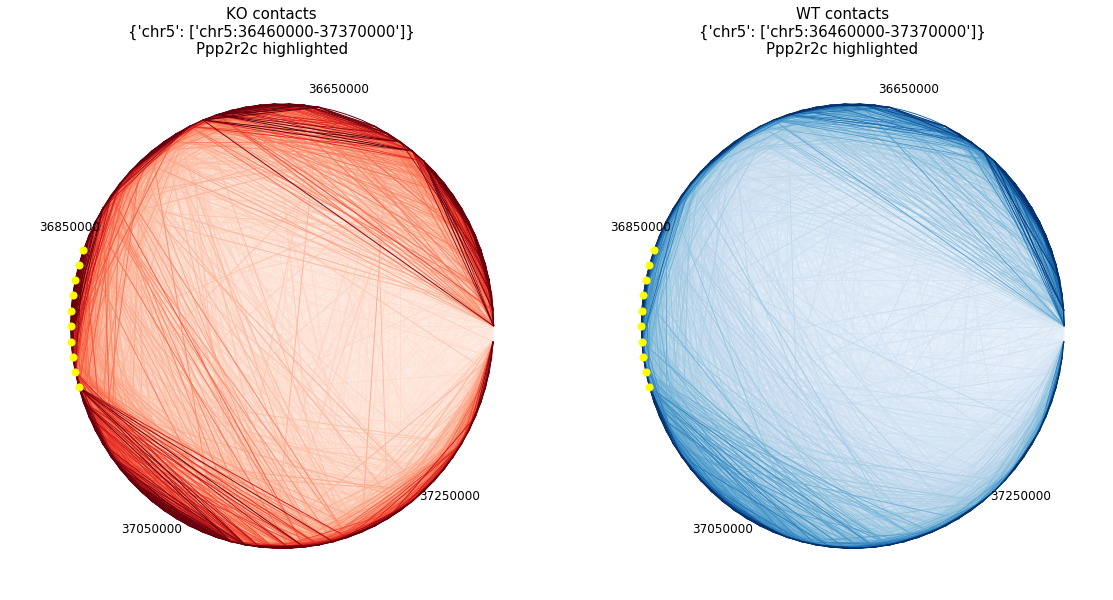

In [18]:
compare_gene(gene_reg = "chr5:36,868,513-36,955,078",gene_name = 'Ppp2r2c')

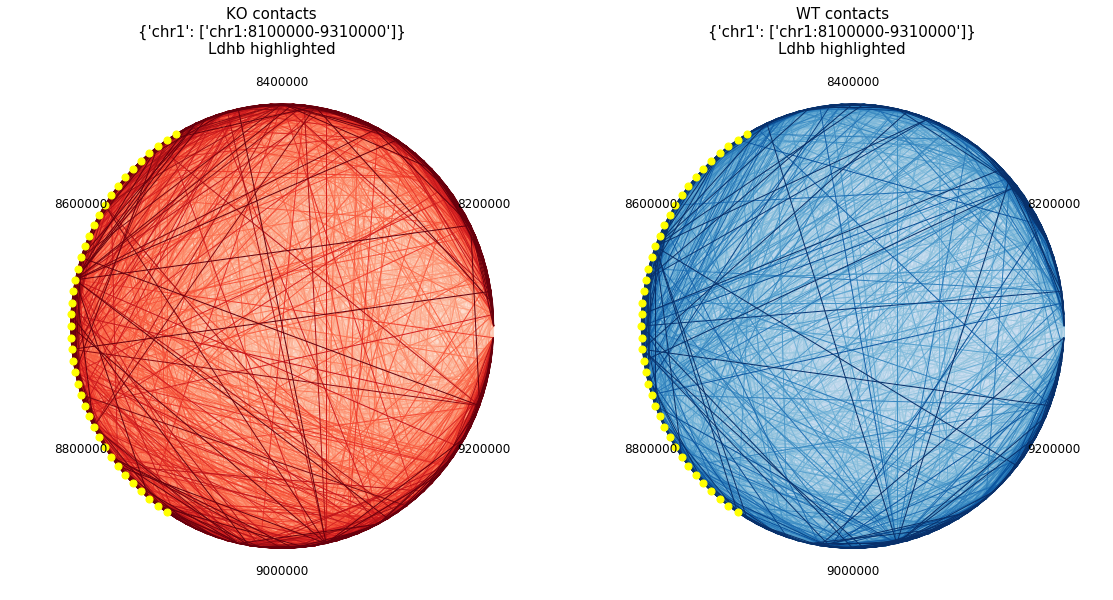

In [8]:
compare_gene(gene_reg = 'chr1:8,500,000-8,900,000',gene_name = 'Ldhb')

In [10]:
graphs = compute_nx_graph_from_regions(coolerpath['WT'],
                                       {'chr1':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr2':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr3':np.array([[8100000,9310000],
                                                         [9340000,10110000]])
                                       },
                                       balance = True, join = True, force_disjoint = True)



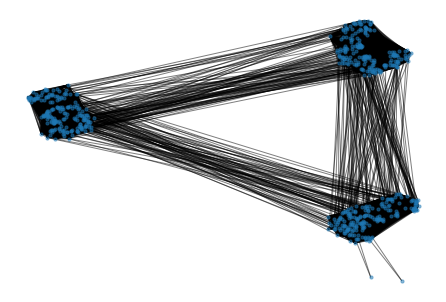

In [11]:
nx.draw(graphs,node_size = 10,alpha = 0.5)

In [12]:
graphs = compute_nx_graph_from_regions(coolerpath['WT'],
                                       {'chr1':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr2':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr3':np.array([[8100000,9310000],
                                                         [9340000,10110000]])
                                       },
                                       balance = True)



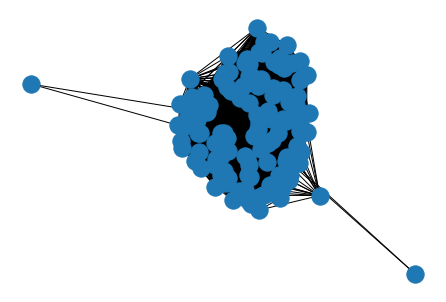

In [15]:
nx.draw(graphs['chr1']['chr1'][0])

In [4]:
from src.utils.parse_cooler import fetch_bins_from_cooler as fbfc
import itertools

In [63]:
rnaseq_path = 'Data/rnaseq.tsv'
rnaseq = pd.read_csv(rnaseq_path,sep = "\t")
rnaseq

,chromosome,prom_start,prom_end,lfc,promoter_ids
0,chr3,108145651,108147137,0.052546,ENSMUSG00000000001
1,chrX,77853128,77854614,-0.002751,ENSMUSG00000000003
2,chr16,18811096,18812978,-0.112532,ENSMUSG00000000028
3,chr7,142576415,142579134,0.528073,ENSMUSG00000000031
4,chrX,161161759,161163555,-0.474546,ENSMUSG00000000037
...,...,...,...,...,...
41464,chr17,29548808,29550294,-0.014677,ENSMUSG00000099329
41465,chr7,44537683,44539169,0.427555,ENSMUSG00000099330
41466,chr11,46169096,46170582,-0.002751,ENSMUSG00000099331
41467,chr17,85617076,85618562,-0.002751,ENSMUSG00000099332


In [44]:
def buffer_regs(regs,
                buff = 5e5,
                lims = [0,1e9]
               ):
    out = np.zeros(regs.shape)
    mean = np.mean(regs,axis = 1).astype('int32')
    out[:,0] = mean - buff
    out[:,1] = mean + buff
    
    out[out<lims[0]] = lims[0]
    out[out>lims[1]] = lims[1]
    
    return out.astype('int32')

In [45]:
c = cooler.Cooler(coolerpath['WT'])

chr_lims = {str(row[0]):int(row[1]) for row in c.chroms()[:].values}

prom_regions = {k1: np.concatenate([item[None,1:3] for item in list(g1)],
                                        axis = 0).astype('int32') for k1,g1 in itertools.groupby(sorted(rnaseq.values,key = lambda x:x[0]),lambda x: x[0])}

lfc = {k1: np.concatenate([item[None,[3]] for item in list(g1)],
                                        axis = 0).astype('float') for k1,g1 in itertools.groupby(sorted(rnaseq.values,key = lambda x:x[0]),lambda x: x[0])}
names = {k1: np.concatenate([item[None,[4]] for item in list(g1)],
                                        axis = 0)[:,0] for k1,g1 in itertools.groupby(sorted(rnaseq.values,key = lambda x:x[0]),lambda x: x[0])}

graph_regions = {chrom: buffer_regs(prom_regions[chrom],lims = [0,chr_lims[chrom]]) for chrom in prom_regions}

In [46]:
chrom = 'chr5'
rdict = {chrom:graph_regions[chrom][:50,:]}
ndict = {chrom: names[chrom][:50]}
glist = compute_ptg_graph_from_regions(coolerpath['WT'],
                                       rdict,
                                       names = ndict,
                                       balance = True,
                                       join = False,
                                       force_disjoint=False,
                                       record_cistrans_interactions = False,
                                       record_node_chromosome_as_onehot = False)


In [51]:
def add_binned_data_to_graph(
    graph: dict,
    binned_data: str
) -> None:
    idxs = graph['cooler_idxs']
    data = pd.read_csv(binned_data, sep = "\t",index_col=0)
    
    graph['x'] = np.append(graph['x'], 
                           data.loc[idxs].values, 
                           axis = 1)
    
def add_binned_data_to_graphlist(
    graph_list: dict,
    binned_data: str
) -> None:
    for graph in graph_list:
        add_binned_data_to_graph(graph, binned_data)
        
add_binned_data_to_graphlist(glist['chr5'],"Data/KR_downsampled_WT_merged_10000_bw_data.tsv")


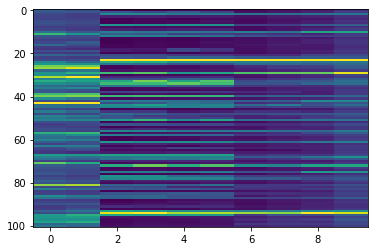

In [54]:
vals = glist['chr5'][27]['x']
maxes = np.max(vals,axis = 0)
vals /= np.repeat(maxes[None,:],vals.shape[0],axis = 0)
plt.imshow(vals,aspect ='auto')

In [55]:
np.savez("test", **glist['chr5'][40])

In [50]:
glist['chr5'][40]

{'edge_index': array([[  0.,   0.,   0., ...,  98.,  98.,  99.],
        [  0.,   1.,   2., ...,  99., 100., 100.]]),
 'edge_attrs': array([[ 68.60409682,   0.        ],
        [112.81367315,   1.        ],
        [ 60.1530931 ,   0.        ],
        ...,
        [ 72.77425234,   1.        ],
        [ 57.25880517,   0.        ],
        [117.48065662,   1.        ]]),
 'x': array([], shape=(101, 0), dtype=float64),
 'cooler_idxs': array([80231, 80232, 80233, 80234, 80235, 80236, 80237, 80238, 80239,
        80240, 80241, 80242, 80243, 80244, 80245, 80246, 80247, 80248,
        80249, 80250, 80251, 80252, 80253, 80254, 80255, 80256, 80257,
        80258, 80259, 80260, 80261, 80262, 80263, 80264, 80265, 80266,
        80267, 80268, 80269, 80270, 80271, 80272, 80273, 80274, 80275,
        80276, 80277, 80278, 80279, 80280, 80281, 80282, 80283, 80284,
        80285, 80286, 80287, 80288, 80289, 80290, 80291, 80292, 80293,
        80294, 80295, 80296, 80297, 80298, 80299, 80300, 80301, 8

In [60]:
idxs = abs(rnaseq['lfc'].values) > np.percentile(abs(rnaseq['lfc'].values),75)

rnaseq.loc[idxs]


,chromosome,prom_start,prom_end,lfc,promoter_ids
2,16,18811096,18812978,-0.112532,ENSMUSG00000000028
3,7,142576415,142579134,0.528073,ENSMUSG00000000031
4,X,161161759,161163555,-0.474546,ENSMUSG00000000037
6,11,121236262,121237748,0.119189,ENSMUSG00000000056
8,13,5860491,5862036,0.146518,ENSMUSG00000000078
...,...,...,...,...,...
41428,X,103604234,103605720,-0.473441,ENSMUSG00000099287
41429,4,134567356,134568842,-0.518670,ENSMUSG00000099289
41431,11,87447636,87449122,-0.178038,ENSMUSG00000099291
41463,15,102948443,102949929,-0.189092,ENSMUSG00000099328
